# Workshop Notebook 3: Observability - Drift Detection

In the previous notebook you learned how to add simple validation rules to a pipeline, to monitor whether outputs (or inputs) stray out of some expected range. In this notebook, you will monitor the *distribution* of the pipeline's predictions to see if the model, or the environment that it runs it, has changed.

## Preliminaries

In the blocks below we will preload some required libraries.

In [78]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
pd.set_option('display.max_colwidth', None)

import sys
 
# setting path - only needed when running this from the `with-code` folder.
sys.path.append('../')

import utils

## Login to Wallaroo

Retrieve the previous workspace, model versions, and pipelines used in the previous notebook.

In [79]:
## blank space to log in 

wl = wallaroo.Client()

# retrieve the previous workspace, model, and pipeline version

workspace_name = 'workshop-workspace-john-cv'

workspace = wl.get_workspace(workspace_name, create_if_not_exist=True)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

model_name = 'mobilenet'

prime_model_version = wl.get_model(model_name)

module_post_process_model = wl.get_model("cv-post-process-drift-detection")

pipeline_name = 'cv-retail-observe'

pipeline = wl.build_pipeline(pipeline_name)

# display the workspace, pipeline and model version
display(workspace)
display(pipeline)
display(prime_model_version)


{'name': 'workshop-workspace-john-cv', 'id': 7, 'archived': False, 'created_by': 'f75a8629-70ab-4100-8b37-04cf79e667ee', 'created_at': '2024-09-19T14:14:59.702317+00:00', 'models': [{'name': 'mobilenet', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 9, 19, 14, 15, 8, 776741, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 9, 19, 14, 15, 8, 776741, tzinfo=tzutc())}, {'name': 'cv-post-process-drift-detection', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 9, 19, 14, 15, 17, 905532, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 9, 19, 14, 15, 17, 905532, tzinfo=tzutc())}], 'pipelines': [{'name': 'cv-retail', 'create_time': datetime.datetime(2024, 9, 19, 14, 16, 17, 873493, tzinfo=tzutc()), 'definition': '[]'}, {'name': 'cv-retail-observe', 'create_time': datetime.datetime(2024, 9, 19, 14, 20, 6, 725196, tzinfo=tzutc()), 'definition': '[]'}]}

name,cv-retail-observe
created,2024-09-19 14:20:06.725196+00:00
last_updated,2024-09-19 20:50:43.719189+00:00
deployed,True
workspace_id,7
workspace_name,workshop-workspace-john-cv
arch,x86
accel,none
tags,
versions,"865362dc-7f0b-4f7a-ba55-011831cf06bb, ee19640f-b6ff-417f-b56a-d7eccf9be3f1, 9579bf4c-5fad-46c1-878f-bb1fe7b63519, 513d4047-a6c7-4aaa-ac73-70f59e3b9f77, 81b2de24-af06-4d4f-817e-46a3ca8fe526, d65ce049-bc91-4ad2-82c2-3d233b9d036f, 1ac20037-f1de-4e35-92d5-e90f17ef1227, 4fda86c1-379d-4eff-b101-5abe36314565"
steps,mobilenet


Name,mobilenet
Version,24c7069e-7372-4701-8cad-a83f05aa54e2
File Name,mobilenet.pt.onnx
SHA,9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830
Status,ready
Image Path,None
Architecture,x86
Acceleration,none
Updated At,2024-19-Sep 14:15:08
Workspace id,7
Workspace name,workshop-workspace-john-cv


Set up the pipeline with the single model step as was done in notebook 1, then deploy it.

In [80]:
pipeline.undeploy()
pipeline.clear()
pipeline.add_model_step(prime_model_version)
pipeline.add_model_step(module_post_process_model)

deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(2).cpus(1).memory("1Gi").build()
pipeline.deploy(deployment_config=deploy_config)

name,cv-retail-observe
created,2024-09-19 14:20:06.725196+00:00
last_updated,2024-09-19 20:51:29.026880+00:00
deployed,True
workspace_id,7
workspace_name,workshop-workspace-john-cv
arch,x86
accel,none
tags,
versions,"7cfd78e2-3fb3-432d-b407-30ffdd8fe33b, 865362dc-7f0b-4f7a-ba55-011831cf06bb, ee19640f-b6ff-417f-b56a-d7eccf9be3f1, 9579bf4c-5fad-46c1-878f-bb1fe7b63519, 513d4047-a6c7-4aaa-ac73-70f59e3b9f77, 81b2de24-af06-4d4f-817e-46a3ca8fe526, d65ce049-bc91-4ad2-82c2-3d233b9d036f, 1ac20037-f1de-4e35-92d5-e90f17ef1227, 4fda86c1-379d-4eff-b101-5abe36314565"
steps,mobilenet


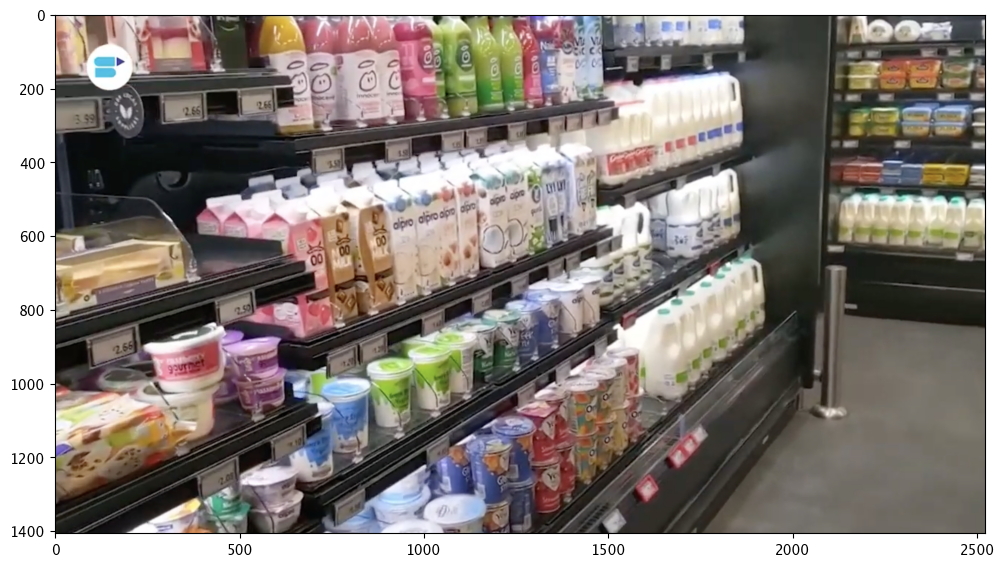

In [82]:
# sample test inference

image = cv2.imread('../data/images/example/dairy_products.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.grid(False)
plt.imshow(image)
plt.show()

In [83]:
width, height = 640, 480
dfImage, resizedImage = utils.loadImageAndConvertToDataframe('../data/images/blurred/dairy_products.png', width, height)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/johnhansarick/Storage/github/training/Workshops/Computer Vision/Retail/data/images/blurred/dairy_products.png'

In [84]:
startTime = time.time()
infResults = pipeline.infer(dfImage)
endTime = time.time()
# display the average confidences
infResults['out.avg_confidence']

InferenceError: Inference failed: {"status":"Error","error":"Error running inference: \"Failed to run: Error calling ONNX Runtime C function: Non-zero status code returned while running Reshape node. Name:'/roi_heads/Reshape' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/reshape_helper.h:35 onnxruntime::ReshapeHelper::ReshapeHelper(const onnxruntime::TensorShape&, onnxruntime::TensorShapeVector&, bool) size != 0 && (input_shape.Size() % size) == 0 was false. The input tensor cannot be reshaped to the requested shape. Input shape:{0,364}, requested shape:{0,-1}\\n\\n\\nStack backtrace:\\n   0: anyhow::error::<impl core::convert::From<E> for anyhow::Error>::from\\n   1: fitzroy::runtimes::onnx::pipeline_session::<impl fitzroy::runtimes::runtime_session::RuntimeSession for fitzroy::runtimes::onnx::session_wrapper::ONNXSessionWrapper>::infer::{{closure}}\\n   2: fitzroy::model::manager::RuntimePool::instance_rx_loop::{{closure}}\\n   3: std::panicking::try\\n   4: tokio::runtime::task::harness::Harness<T,S>::poll\\n   5: tokio::runtime::scheduler::multi_thread::worker::Context::run_task\\n   6: tokio::runtime::scheduler::multi_thread::worker::Context::run\\n   7: tokio::runtime::context::scoped::Scoped<T>::set\\n   8: tokio::runtime::context::runtime::enter_runtime\\n   9: tokio::runtime::scheduler::multi_thread::worker::run\\n  10: <tokio::runtime::blocking::task::BlockingTask<T> as core::future::future::Future>::poll\\n  11: tokio::runtime::task::core::Core<T,S>::poll\\n  12: tokio::runtime::task::harness::Harness<T,S>::poll\\n  13: tokio::runtime::blocking::pool::Inner::run\\n  14: std::sys_common::backtrace::__rust_begin_short_backtrace\\n  15: core::ops::function::FnOnce::call_once{{vtable.shim}}\\n  16: std::sys::pal::unix::thread::Thread::new::thread_start\\n  17: start_thread\\n  18: clone\""}

## Monitoring for Drift: Shift Happens. 

In machine learning, you use data and known answers to train a model to make predictions for new previously unseen data. You do this with the assumption that the future unseen data will be similar to the data used during training: the future will look somewhat like the past.
But the conditions that existed when a model was created, trained and tested can change over time, due to various factors.

A good model should be robust to some amount of change in the environment; however, if the environment changes too much, your models may no longer be making the correct decisions. This situation is known as concept drift; too much drift can obsolete your models, requiring periodic retraining.

Let's consider the example we've been working on: home sale price prediction. You may notice over time that there has been a change in the mix of properties in the listings portfolio: for example a dramatic increase or decrease in expensive properties (or more precisely, properties that the model thinks are expensive)

Such a change could be due to many factors: a change in interest rates; the appearance or disappearance of major sources of employment; new housing developments opening up in the area. Whatever the cause, detecting such a change quickly is crucial, so that the business can react quickly in the appropriate manner, whether that means simply retraining the model on fresher data, or a pivot in business strategy.

In Wallaroo you can monitor your housing model for signs of drift through the model monitoring and insight capability called Assays. Assays help you track changes in the environment that your model operates within, which can affect the model’s outcome. It does this by tracking the model’s predictions and/or the data coming into the model against an **established baseline**. If the distribution of monitored values in the current observation window differs too much from the baseline distribution, the assay will flag it. The figure below shows an example of a running scheduled assay.


![](https://docs.wallaroo.ai/images/current/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights-reference_files/wallaroo-model-insights-reference_35_0.png)

**Figure:** A daily assay that's been running for a month. The dots represent the difference between the distribution of values in the daily observation window, and the baseline. When that difference exceeds the specified threshold (indicated by a red dot) an alert is set.

This next set of exercises will walk you through setting up an assay to monitor the predictions of your house price model, in order to detect drift.

### NOTE

An assay is a monitoring process that typically runs over an extended, ongoing period of time. For example, one might set up an assay that every day monitors the previous 24 hours' worth of predictions and compares it to a baseline. For the purposes of these exercises, we'll be compressing processes what normally would take hours or days into minutes.


## Set Assay Baseline

In order to know whether the distribution of your model's predictions have changed, you need a baseline to compare them to. This baseline should represent how you expect the model to behave at the time it was trained. This might be approximated by the distribution of the model's predictions over some "typical" period of time. For example, we might collect the predictions of our model over the first few days after it's been deployed. For these exercises, we'll compress that to a few minutes. Currently, to set up a wallaroo assay the pipeline must have been running for some period of time, and the assumption is that this period of time is "typical", and that the distributions of the inputs and the outputs of the model during this period of time are "typical."


## Create Set Baseline

Before setting up an assay on this pipeline's output, we may want to look at the distribution of the predictions over our selected baseline period. First we'll perform a set of inferences and use that data to create our baseline values.  These are either a date period of inferences to look at, or a numpy array generated from the sample data.

### Create Set Baseline Example

Create an assay builder to monitor the output of your house price pipeline. The baseline period should be from `baseline_start` to `baseline_end`. 

* You will need to know the name of your output variable, and the name of the model in the pipeline.  In our case, we will be relying on the post processing Python model we deployed with the pipeline.

Here's an example.

```python
import datetime
import time

baseline_start = datetime.datetime.now()
time.sleep(5)

image_path = '../data/images/example'

import os
# get a list of all of the images in the directory
files = os.listdir(image_path)

width, height = 640, 480

inference_list = []

# render each image to a DataFrame, and add it to the list
for image in files:
    display(image)
    dfImage, resizedImage = utils.loadImageAndConvertToDataframe(f'{image_path}/{image}', 
                                                              width, 
                                                              height
                                                              )
    inference_list.append(dfImage)

# use the pipeline.parallel_infer to submit the entire list of dataframes as a single request.
parallel_results = await pipeline.parallel_infer(tensor_list=inference_list, timeout=120, num_parallel=2, retries=5)

# set the time to sleep just for comparision
time.sleep(30)

baseline_end = datetime.datetime.now()

# turn baseline of out.avg_conf into numpy arrays

assay_baseline_logs = pipeline.logs(start_datetime=baseline_start, end_datetime=baseline_end)

# set the results to a non-array value
results_baseline_df = assay_baseline_logs.copy()
# get the numpy values
results_baseline = results_baseline_df['out.avg_conf'].to_numpy()
results_baseline


```


In [85]:
baseline_start = datetime.datetime.now(datetime.timezone.utc)

## Blank space to create an assay builder and examine the baseline distribution

blurred_images = [
    "../data/images/blurred/blurred-dairy_bottles.png",
    "../data/images/blurred/blurred-dairy_products.png",
    "../data/images/blurred/blurred-coats-jackets.png"
]

blurred_images = [
    "../data/images/blurred/blurred-dairy_products.png",
    "../data/images/blurred/blurred-example_05.jpg",
    "../data/images/blurred/blurred-example_06.jpg",
    "../data/images/blurred/blurred-store-front.png",
]



baseline_images = [
    "../data/images/example/dairy_products.png",
    "../data/images/example/example_05.jpg",
    "../data/images/example/example_06.jpg",
    "../data/images/example/store-front.png",
]

# import os
# files = os.listdir(image_path)

width, height = 640, 480

dfImage_baseline = pd.DataFrame()

time.sleep(65)

for image in baseline_images:
    display(image)
    dfImage_temp, resizedImage = utils.loadImageAndConvertToDataframe(f'{image}', 
                                                              width, 
                                                              height
                                                              )
    dfImage_baseline = dfImage_baseline.append(dfImage_temp)

dfImage_blurred = pd.DataFrame()

for image in blurred_images:
    display(image)
    dfImage_temp, resizedImage = utils.loadImageAndConvertToDataframe(f'{image}', 
                                                              width, 
                                                              height
                                                              )
    dfImage_blurred = dfImage_blurred.append(dfImage_temp)

parallel_results = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
display(parallel_results['out.avg_confidence'])
display(parallel_results['out.avg_confidence'].mean())

time.sleep(65)

baseline_end = datetime.datetime.now(datetime.timezone.utc)

'../data/images/example/dairy_products.png'

'../data/images/example/example_05.jpg'

'../data/images/example/example_06.jpg'

'../data/images/example/store-front.png'

'../data/images/blurred/blurred-dairy_products.png'

'../data/images/blurred/blurred-example_05.jpg'

'../data/images/blurred/blurred-example_06.jpg'

'../data/images/blurred/blurred-store-front.png'

0    0.216424
1    0.476583
2    0.395064
3    0.318532
Name: out.avg_confidence, dtype: float64

0.35165052500000005

In [86]:
parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
display(parallel_results_blurred['out.avg_confidence'])
display(parallel_results_blurred['out.avg_confidence'].mean())

0    0.119952
1    0.218508
2    0.266491
3    0.263704
Name: out.avg_confidence, dtype: float64

0.2171639265

In [87]:
# turn baseline of out.avg_confidence into numpy arrays

# get the numpy values
results_baseline = parallel_results['out.avg_confidence'].to_numpy()
results_baseline

array([0.2164243 , 0.47658256, 0.39506358, 0.31853166])

## Create Assay

Baselines are created with the `wallaroo.client.build_assay` method and take the following arguments.

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | (*String*) (*Required*) | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | (*wallaroo.pipeline*) (*Required*) | The pipeline the assay retrieves data from. |
| **model_name** | (*String*) (*Required*) | The name of the model.  This must be one of the models deployed in the pipeline. |
| **iopath** | (*String*) (*Required*) | The input/output path of "output|input {field_name} {field_index}".  For example, `"output avg_conf 0"` to use the model's outputs field `avg_conf` at index `0` |
| **baseline_start** | (*datetime.datetime*) (*Optional*) | The start time for the inferences to use as the baseline.  If `baseline_start` is used, it **must** be paired with `baseline_end` and **not** `baseline_data`.
| **baseline_end** | (*datetime.datetime*) (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continously until the assay is deactivated or deleted.  If `baseline_end` is used, it **must** be paired with `baseline_start` and **not** `baseline_data`.
| **baseline_data** | (*numpy.array*) (*Optional*) | The baseline data in numpy array format.  If `baseline_data` is used, `baseline_start` and `baseline_end` must **not** be used. |

Baseline data **must** be either `baseline_start` **and** `baseline_end`, or **baseline_data**.

### Create Assay Exercise

For this exercise, we will create the assay, then display the baseline histogram from the assay.

Sample code:

```python
suffix = '-FIRSTNAME-LASTNAME'

assay_builder = (
    wl.build_assay(
        assay_name = f'sample assay cv sample{suffix}',
        pipeline=pipeline,
        model_name = module_post_process_model_name,
        iopath="output avg_conf 0",
        baseline_data=results_baseline
    )
)

assay_builder.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_config = assay_builder.build()
assay_analysis = assay_config.interactive_run()

assay_builder.baseline_histogram()
```

In [88]:

assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_confidence 0",
                               baseline_data = results_baseline)


# create the baseline from the dates
assay_baseline_run_from_dates = assay_baseline_from_dates.build().interactive_baseline_run()
assay_baseline_run_from_dates.baseline_stats()

,Baseline
count,4
min,0.216424
max,0.476583
mean,0.351651
median,0.356798
std,0.096015
start,None
end,None


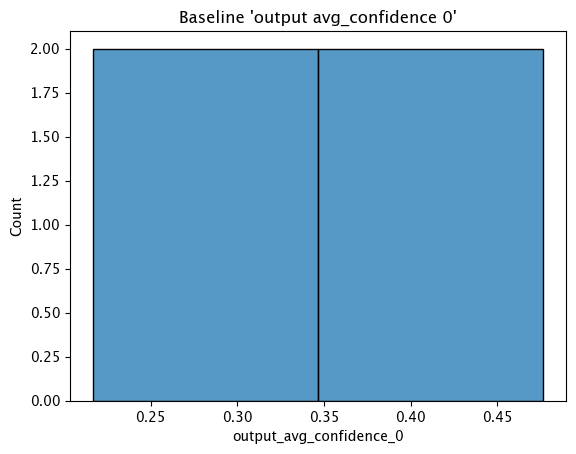

In [89]:
assay_baseline_from_dates.baseline_histogram()

## Assay Windows

An assay should detect if the distribution of model predictions changes from the above distribution over regularly sampled observation windows. This is called *drift*.

To show drift, we'll run more data through the pipeline -- first some data drawn from the same distribution as the baseline (`lowprice_data`). Then, we will gradually introduce more data from a different distribution (`highprice_data`). We should see the difference between the baseline distribution and the distribution in the observation window increase.

To set up the data, you should do something like the below. It will take a while to run, because of all the `sleep` intervals.

You will need the `assay_window_end` for a later exercise.

**IMPORTANT NOTE**:  To generate the data for the assay, this process may take 4-5 minutes.  Because the shortest period of time for an assay window is 1 minute, the intervals of inference data are spaced to fall within that time period.

```python

import datetime
import time

window_start = datetime.datetime.now()

# run a set of blurred images

image_path = '../data/images/blurred'

import os
files = os.listdir(image_path)

width, height = 640, 480

inference_list = []

for image in files:
    display(image)
    dfImage, resizedImage = utils.loadImageAndConvertToDataframe(f'{image_path}/{image}', 
                                                              width, 
                                                              height
                                                              )
    inference_list.append(dfImage)

# run a second set of data with "good" values
time.sleep(5)

image_path = '../data/images/example'

import os
files = os.listdir(image_path)

width, height = 640, 480

inference_list = []

for image in files:
    display(image)
    dfImage, resizedImage = utils.loadImageAndConvertToDataframe(f'{image_path}/{image}', 
                                                              width, 
                                                              height
                                                              )
    inference_list.append(dfImage)

parallel_results = await pipeline.parallel_infer(tensor_list=inference_list, timeout=120, num_parallel=4, retries=5)

time.sleep(65)

window_end = datetime.datetime.now()
```


In [91]:
## Blank space to create an assay builder and examine the baseline distribution

# run a set of normal images

import datetime
import time

assay_window_start = datetime.datetime.now(datetime.timezone.utc)
time.sleep(66)

In [92]:

# setting up the for loop

# regular images
for x in range(10):
    parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
time.sleep(65)

for x in range(9):
    parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
time.sleep(65)
for x in range(1):
    parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
time.sleep(65)

for x in range(8):
    parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
time.sleep(65)
for x in range(2):
    parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
time.sleep(65)

# for x in range(7):
#     parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)
# for x in range(3):
#     parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)

# for x in range(6):
#     parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)
# for x in range(5):
#     parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)

# for x in range(5):
#     parallel_results_baseline = await pipeline.parallel_infer(tensor=dfImage_baseline, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)
# for x in range(5):
#     parallel_results_blurred = await pipeline.parallel_infer(tensor=dfImage_blurred, timeout=120, num_parallel=2, retries=5)
# time.sleep(65)

In [93]:
assay_window_end = datetime.datetime.now(datetime.timezone.utc)

## Define Assay Parameters

Now we're finally ready to set up an assay!

### The Observation Window

Once a baseline period has been established, you must define the window of observations that will be compared to the baseline. For instance, you might want to set up an assay that runs *every 12 hours*, collects the *previous 24 hours' predictions* and compares the distribution of predictions within that 24 hour window to the baseline. To set such a comparison up would look like this:

```python
assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)
```

In other words **_width_** is the width of the observation window, and **_interval_** is how often an assay (comparison) is run. The default value of *width* is 24 hours; the default value of *interval* is to set it equal to *width*. The units can be specified in one of: `minutes`, `hours`, `days`, `weeks`.

### The Comparison Threshold
Given an observation window and a baseline distribution, an assay computes the distribution of predictions in the observation window. It then calculates the "difference" (or "distance") between the observed distribution and the baseline distribution. For the assay's default distance metric (which we will use here), a good starting threshold is 0.1. Since a different value may work best for a specific situation, you can try interactive assay runs on historical data to find a good threshold, as we do in these exercises.

To set the assay threshold for the assays to 0.1:

```python
assay_builder.add_alert_threshold(0.1)
```

### Running an Assay on Historical Data

In this exercise, you will build an **interactive assay** over historical data. To do this, you need an end time (`endtime`). 

Depending on the historical history, the window and interval may need adjusting.  If using the previously generated information, an interval window as short as 1 minute may be useful.

Assuming you have an assay builder with the appropriate window parameters and threshold set, you can do an interactive run and look at the results would look like this.

By default, assay start date is set to 24 hours from when the assay was created.  For this example, we will set the `assay.window_builder.add_start` to set the assay window to start at the beginning of our data, and `assay.add_run_until` to set the time period to stop gathering data from.

```python
# set the end of the interactive run
assay_builder.add_run_until(endtime)

# set the window

assay_builder.window_builder().add_width(hours=24).add_interval(hours=12).add_start(start_time)

assay_results = assay_builder.build().interactive_run()
df = assay_results.to_dataframe() # to return the results as a table
assay_results.chart_scores() # to plot the run
```

### Define Assay Parameters Exercise

Use the assay_builder you created in the previous exercise to set up an interactive assay. 
* The assay should run every minute, on a window that is a minute wide. 
* Set the alert threshold to 0.1.  
* You can use `assay_window_end` (or a later timestamp) as the end of the interactive run.

Examine the assay results. Do you see any drift?

To try other ways of examining the assay results, see the ["Interactive Assay Runs" section of the Model Insights tutorial](https://docs.wallaroo.ai/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights/#interactive-assay-runs).

Here's some code to use.

```python
# blank space for setting assay parameters, creating and examining an interactive assay

assay_builder.add_run_until(window_end)
assay_builder.window_builder().add_start(window_start)
assay_builder.window_builder().add_interval(minutes=1).add_width(minutes=1)
assay_config = assay_builder.build()
assay_analysis = assay_config.interactive_run()

df = assay_analysis.to_dataframe() # to return the results as a table
display(df)
assay_analysis.chart_scores() # to plot the run

```


In [105]:
assay_baseline = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_confidence 0",
                               baseline_data = results_baseline)


# # create the baseline from the dates
assay_baseline_run_from_dates = assay_baseline.build().interactive_baseline_run()
assay_baseline_run_from_dates.baseline_stats()

# # The end date to gather inference results
assay_baseline.add_run_until(datetime.datetime.now(datetime.timezone.utc))

# # Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)

# build the assay configuration
assay_config = assay_baseline.build()

# perform an interactive run and collect inference data
assay_results = assay_config.interactive_run()

# # build the assay configuration
# assay_config = assay_baseline.build()

# # perform an interactive run and collect inference data
# assay_results = assay_config.interactive_run()

# # Preview the assay analyses
# # assay_results.chart_scores()

TypeError: Parser must be a string or character stream, not NoneType

## Schedule an Assay for Ongoing Data

(We won't be doing an exercise here, this is for future reference).

Once you are satisfied with the parameters you have set, you can schedule an assay to run regularly .

```python
# create a fresh assay builder with the correct parameters
assay_builder = ( wl.build_assay(assay_name, pipeline, model_name, 
                     baseline_start, baseline_end)
                    .add_iopath("output variable 0") )

# this assay runs every 24 hours on a 24 hour window
assay_builder.window_builder().add_width(hours=24)
assay_builder.add_alert_threshold(0.1)

# now schedule the assay
assay_id = assay_builder.upload()
```

You can use the assay id later to get the assay results.

In [ ]:
# assay_id = assay_builder.upload()

## Cleaning up.

Now that the workshop is complete, don't forget to undeploy your pipeline to free up the resources.


In [ ]:
# blank space to undeploy your pipeline

pipeline.undeploy()


You have now walked through setting up a basic assay and running it over historical data.

## Congratulations!

In this workshop you have
* Deployed a single step house price prediction pipeline and sent data to it.
* Compared two house price prediction models in an A/B test
* Compared two house price prediction models in a shadow deployment.
* Swapped the "winner" of the comparisons into the house price prediction pipeline.
* Set validation rules on the pipeline.
* Set up an assay on the pipeline to monitor for drift in its predictions.

Great job!